In [ ]:
!pip install stanza

     |████████████████████████████████| 337 kB 4.3 MB/s 


In [ ]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [ ]:
# Download dataset from Kaggle
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

 99% 769M/780M [00:29<00:00, 23.9MB/s]
100% 780M/780M [00:29<00:00, 27.9MB/s]


In [ ]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/2019_all_twitter_data/2019_all_twitter_data.csv  
  inflating: /content/data/bot_df/bot_df.csv  
  inflating: /content/data/clean_twitter_data/all_2019.csv  
  inflating: /content/data/clean_twitter_data/all_users.csv  
  inflating: /content/data/clean_twitter_data/pol_actor_users.csv  
  inflating: /content/data/ge2017_cand_data/ge2017_cand_data.csv  
  inflating: /content/data/twitter_data/all_twitter_data.csv  
  inflating: /content/data/twitter_data/political_twitter_data.csv  


In [ ]:
# Import libaries 
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

import stanza
stanza.download('en')

sns.set_style('whitegrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2021-07-27 12:35:08 INFO: Downloading default packages for language: en (English)...


2021-07-27 12:36:31 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
# Initialize stanza pipeline for sentiment analysis  
nlp = stanza.Pipeline('en', processors='tokenize,sentiment')

2021-07-27 12:38:32 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-07-27 12:38:32 INFO: Use device: cpu
2021-07-27 12:38:32 INFO: Loading: tokenize
2021-07-27 12:38:33 INFO: Loading: sentiment
2021-07-27 12:38:33 INFO: Done loading processors!


In [ ]:
# Read csv files to Pandas DataFrame
all_2019_df = pd.read_csv('/content/data/2019_all_twitter_data/2019_all_twitter_data.csv', encoding='cp1252')
score_df = pd.read_csv('/content/botscores.txt', delimiter=',', header=None)
score_df.columns = ['score', 'user']

Text(0.5, 1.0, 'Distribution of Bot Scores')

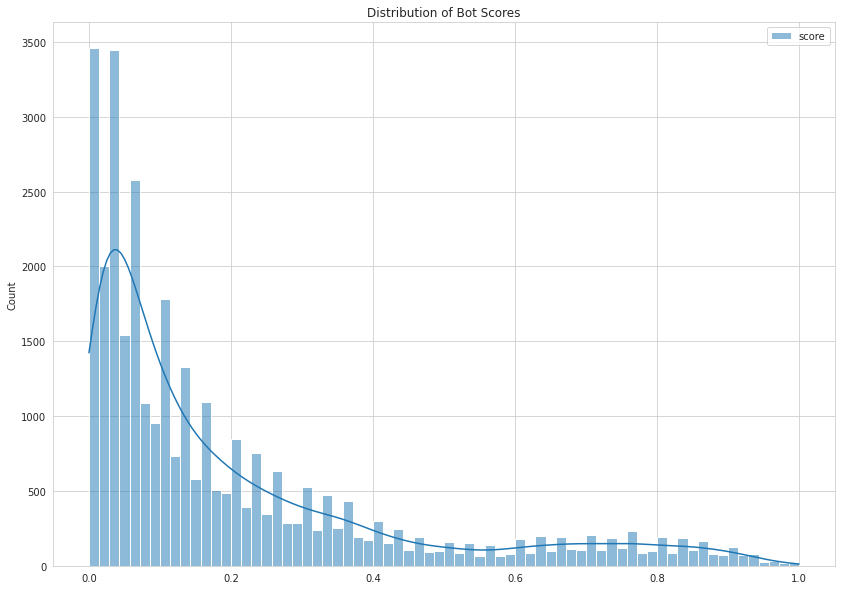

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sns.histplot(data=score_df, kde=True)
ax.set_title('Distribution of Bot Scores')

In [ ]:
# Merge Twitter data with bot scores and creates an bot and human dataframe
all_2019_df = pd.merge(left=score_df, right=all_2019_df, left_on='user', right_on='quotedTweet_username')
all_2019_df = all_2019_df.drop(columns=['user'])
bot_df = all_2019_df[~(all_2019_df['score'] < 0.87)]
human_df = all_2019_df[~(all_2019_df['score'] > 0.5)]

In [ ]:
# Number of bots in data
len(bot_df['quotedTweet_username'].unique())

615

In [ ]:
# Removes time from date column and converts from string to datetime type
bot_df['tweet_date'] = bot_df['tweet_date'].map(lambda x: str(x)[:-15])
bot_df['tweet_date'] = pd.to_datetime(bot_df['tweet_date'])
bot_df = bot_df[~(bot_df['tweet_date'] < '2019-11-06')]

human_df['tweet_date'] = human_df['tweet_date'].map(lambda x: str(x)[:-15])
human_df['tweet_date'] = pd.to_datetime(human_df['tweet_date'])
human_df = human_df[~(human_df['tweet_date'] < '2019-11-06')]

In [ ]:
punc = list(string.punctuation)
stop = stopwords.words('english') + punc + ['rt', 'via']

tt = TweetTokenizer()

In [ ]:
def hashtag_extract(s):
  '''
  Function which uses an regular expression to find hashtags in an tweet and return them as an list
  :param s (string): String of an tweet
  :return hashtags (list): list of hashtags
  '''
  hashtags = []
  for i in s:
    ht = re.findall(r"#(\w+)", i)
    hashtags.append(ht)
  return hashtags

In [ ]:
def fix_encode(df):
  '''
  Function to remove trailing characters from encode error when collecting data
  :param df (DataFrame): 
  :return df (DataFrame):
  '''
  df['tweet_content'] = df['tweet_content'].str.replace('&amp', '&')
  df['tweet_content'] = df['tweet_content'].str.replace('b"', '')
  df['tweet_content'] = df['tweet_content'].str.replace("b'", '')
  return df

In [ ]:
def join_punct(s):
  '''
  Removes punctuation from string
  :param s (string): String with punctuation
  :return s (string): String with puncutaion removed
  '''
    return ''.join(ch for ch in s if ch not in punc)

In [ ]:
def remove_emoji(s):
  '''
  Removes unicode characters (emojis) from string
  '''
    emoji_pattern = re.compile(
        r'(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff]|(?:\U0001f92d))',
        re.UNICODE)
    return emoji_pattern.sub(r'', s)

In [ ]:
def remove_url(s):
  '''
  Removes URL from string
  '''
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', s)
    return no_url

In [ ]:
def clean_tweet(s):
  '''
  Function which tokenizes tweet, removes punctuation, url, emoji and stopwords and converts tweet to same case (lower) 
  :param s (string): 
  :return clean_tweets (list): token list from s
  '''
  clean_tweets = []
  for i in s:
    tweet_token = tt.tokenize(join_punct(remove_emoji(remove_url(i.lower()))))
    no_stop_words = [token for token in tweet_token if not token in stop]
    clean_tweets.append(no_stop_words)
  return clean_tweets

In [ ]:
def preprocessing_user(df):
  '''
  Cleans user columns in dataframe. When collecting data an User object is collected. We only need the user name so this is filtered here
  For more information on twitter user objects see below
  https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/user
  '''

  df['mentioned_users']=df['mentioned_users'].fillna("")
  mentioned_user = []
  for i, user in enumerate(df['mentioned_users']):
    usernames = user.split("username='")
    username_list = []
    for username in usernames:
      username_list.append(re.findall("^(.+?)'", username))
    mentioned_user.append(username_list[1:])
  df = df.drop(columns=['mentioned_users'])
  df['mentioned_users'] = mentioned_user
  df['mentioned_users'] = df['mentioned_users'].apply(lambda x: np.nan if len(x)==0 else x)

  df['quotedTweet_mentionedUsers']=df['quotedTweet_mentionedUsers'].fillna("")
  mentioned_user = []
  for i, user in enumerate(df['quotedTweet_mentionedUsers']):
    usernames = user.split("username='")
    username_list = []
    for username in usernames:
      username_list.append(re.findall("^(.+?)'", username))
    mentioned_user.append(username_list[1:])
  df = df.drop(columns=['quotedTweet_mentionedUsers'])
  df['quotedTweet_mentionedUsers'] = mentioned_user
  df['quotedTweet_mentionedUsers'] = df['quotedTweet_mentionedUsers'].apply(lambda x: np.nan if len(x)==0 else x)

  return df

In [ ]:
def clean_sentiment(s):
  '''
  Cleans tweet for sentiment analysis
  '''
  clean_tweets = []
  for i in s:
    x = join_punct(remove_url(i.lower()))
    clean_tweets.append(x)
  return clean_tweets

In [ ]:
def sentiment(df, col):
  '''
  Performs sentiment anlysis on column
  :param df (DataFrame): Dataframe which contains data
  :param col (String): Name of the column of the dataframe which needs to be analysised
  :return dataframe (DataFrame): Dataframe of 2 columns - sentiment and text
  '''
  rows = []
  for tweet in df[col]:
    doc = nlp(tweet)
    for sentence in doc.sentences:
      row={
          'text_'+col: sentence.text,
          'sentiment_'+col: sentence.sentiment
      }
    rows.append(row)
  return pd.DataFrame(rows)

In [ ]:
# Calls functions on human dataset
human_df = fix_encode(human_df)
human_df['hashtags'] = hashtag_extract(human_df['tweet_content'])
human_df['quoted_hashtags'] = hashtag_extract(human_df['quotedTweet_content'])
human_df['clean_tweet_content'] = clean_tweet(human_df['tweet_content'])
human_df['clean_quotedTweet_content'] = clean_tweet(human_df['quotedTweet_content'])
human_df = preprocessing_user(human_df)

In [ ]:
# Calls functions on bot dataset
bot_df = fix_encode(bot_df)
bot_df['hashtags'] = hashtag_extract(bot_df['tweet_content'])
bot_df['quoted_hashtags'] = hashtag_extract(bot_df['quotedTweet_content'])
bot_df['clean_tweet_content'] = clean_tweet(bot_df['tweet_content'])
bot_df['clean_quotedTweet_content'] = clean_tweet(bot_df['quotedTweet_content'])
bot_df = preprocessing_user(bot_df)
bot_df['clean_sentiment_content'] = clean_sentiment(bot_df['tweet_content'])
bot_df['clean_sentiment_quoted'] = clean_sentiment(bot_df['quotedTweet_content'])
sentiment_2019_df = sentiment(bot_df, 'clean_sentiment_content')
all_2019_sent_df=sentiment_2019_df.merge(right=bot_df, left_on='text_clean_sentiment_content', right_on='clean_sentiment_content')
sentiment_2019_quoted_df = sentiment(bot_df, 'clean_sentiment_quoted')
final_df=sentiment_2019_quoted_df.merge(right=all_2019_sent_df, left_on='text_clean_sentiment_quoted', right_on='clean_sentiment_quoted')
final_df = final_df.drop(columns=['text_clean_sentiment_quoted', 'text_clean_sentiment_content', 'clean_sentiment_content', 'clean_sentiment_quoted'])

In [ ]:
!mkdir output

In [ ]:
human_df.to_csv('output/human_df.csv')
bot_df.to_csv('output/final_df.csv')

In [ ]:
!zip -r /content/output.zip /content/output